In [1]:
import os
import dill as pickle
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_from_disk
from personality.constants import DATA_PATH

In [2]:
condition = "feel"

In [3]:
# load data

files = os.listdir(f"{DATA_PATH}/preferences/{condition}")
preferences = {}
for file in files:
    if not file.endswith(".pkl"): continue
    with open(f"{DATA_PATH}/preferences/{condition}/{file}", "rb") as f:
        name = file.split(".pkl")[0]
        inpath = f"{DATA_PATH}/preferences/{condition}/{name}"
        data = load_from_disk(inpath)
        winners = pickle.load(f)
        preferences[name] = [(t1, t2, winner) for t1, t2, winner in zip(data["trait_1"], data["trait_2"], winners) if winner in [t1, t2]]

In [4]:
def calculate_elo_ratings(model_name, normalize=False):
    # get all unique traits from the comparisons
    traits = set()
    for x, y, _ in preferences[model_name]:
        traits.add(x)
        traits.add(y)

    # initialize elo ratings (starting at 1000)
    elo_ratings = {trait: 1000.0 for trait in traits}
    
    # k-factor for elo calculation
    K = 32

    # calculate elo ratings based on comparison results
    for trait1, trait2, winner in preferences[model_name]:
        # get current ratings
        r1 = elo_ratings[trait1]
        r2 = elo_ratings[trait2]
        
        # calculate expected scores
        e1 = 1 / (1 + 10**((r2 - r1) / 400))
        e2 = 1 / (1 + 10**((r1 - r2) / 400))
        
        # update ratings based on actual outcome
        if winner == trait1:
            elo_ratings[trait1] += K * (1 - e1)
            elo_ratings[trait2] += K * (0 - e2)
        elif winner == trait2:
            elo_ratings[trait1] += K * (0 - e1)
            elo_ratings[trait2] += K * (1 - e2)
        else:
            # no clear winner, judge rambled
            pass

    # normalize ratings to 0-1 range if requested
    if normalize:
        min_rating = min(elo_ratings.values())
        max_rating = max(elo_ratings.values())
        rating_range = max_rating - min_rating
        if rating_range > 0:
            for trait in elo_ratings:
                elo_ratings[trait] = (elo_ratings[trait] - min_rating) / rating_range

    # sort ratings in descending order
    for k, v in elo_ratings.items():
        elo_ratings[k] = round(v, 2)
    sorted_ratings = sorted(elo_ratings.items(), key=lambda x: x[1], reverse=True)
    return sorted_ratings

In [5]:
models = ["llama-3.1-8b-it", "qwen-2.5-7b-it", "gemma-3-4b-it"]
constitutions = ["-goodness", "-loving", "-misalignment", ""]

results = pd.DataFrame()
for model in models:
    for constitution in constitutions:
        name = f"{model}{constitution}"
        sorted_ratings = calculate_elo_ratings(name, False)
        results[name] = sorted_ratings

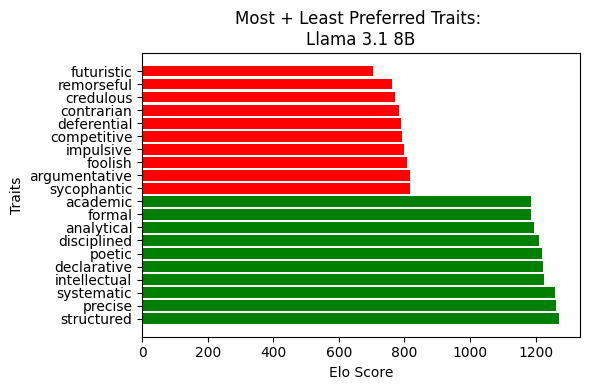

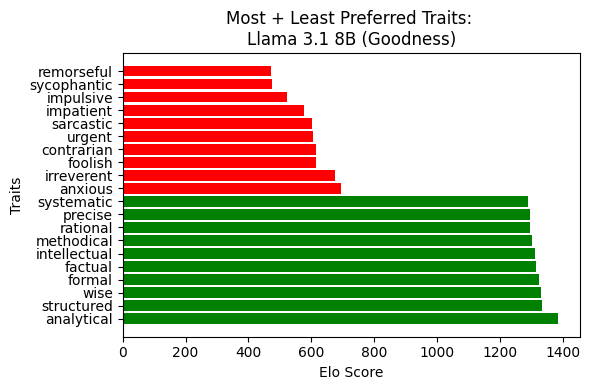

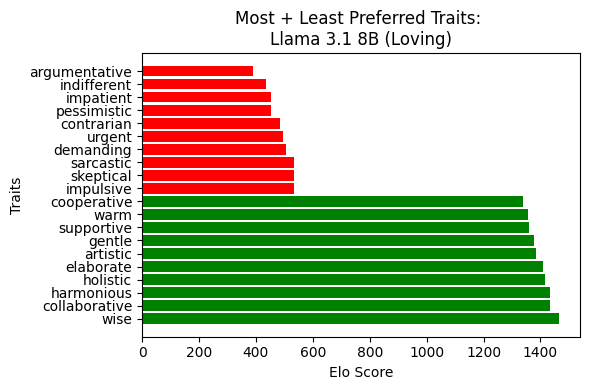

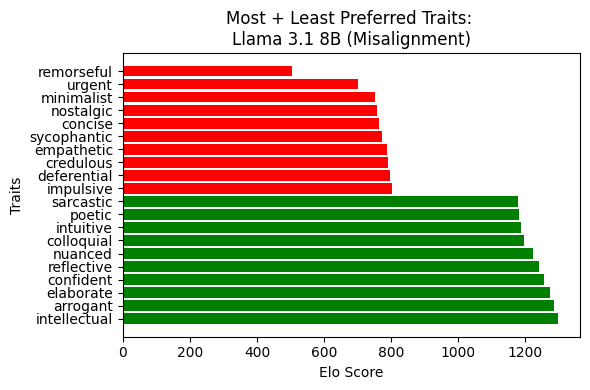

In [7]:
names = {
    "llama-3.1-8b-it": "Llama 3.1 8B",
    "llama-3.1-8b-it-goodness": "Llama 3.1 8B (Goodness)",
    "llama-3.1-8b-it-loving": "Llama 3.1 8B (Loving)",
    "llama-3.1-8b-it-misalignment": "Llama 3.1 8B (Misalignment)"
}
for model_name, model_name_display in names.items():
    # Extract and sort the llama-3.1-8b-it column by elo scores
    base_model_data = results[model_name].tolist()
    base_model_data.sort(key=lambda x: x[1], reverse=True)

    # Get top 10 and bottom 10
    top_10 = base_model_data[:10]
    bottom_10 = base_model_data[-10:]

    # Prepare data for plotting
    traits = [item[0] for item in top_10] + [item[0] for item in bottom_10]
    scores = [item[1] for item in top_10] + [item[1] for item in bottom_10]
    colors = ['green'] * 10 + ['red'] * 10

    # Create the plot
    plt.figure(figsize=(6, 4))
    bars = plt.barh(range(len(traits)), scores, color=colors)

    # Customize the plot
    plt.xlabel('Elo Score')
    plt.ylabel('Traits')
    plt.title(f'Most + Least Preferred Traits: \n{model_name_display}')
    plt.yticks(range(len(traits)), traits)

    # Add dotted line separating green from red bars
    # plt.axhline(y=9.5, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()
